In [2]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [10]:
print(tf.__version__)

2.16.1


In [11]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url, untar=True, cache_dir='.', cache_subdir='')

print(dataset)

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")

./aclImdb_v1


In [7]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [8]:
train_dir = os.path.join(dataset_dir, "train")
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [9]:
print("--- negative review example ---")
sample_file = os.path.join(train_dir, 'neg/1_1.txt')
with open(sample_file) as f:
  print(f.read())

print()

print("--- positive review example ---")
sample_file = os.path.join(train_dir, 'pos/0_9.txt')
with open(sample_file) as f:
  print(f.read())

--- negative review example ---
Robert DeNiro plays the most unbelievably intelligent illiterate of all time. This movie is so wasteful of talent, it is truly disgusting. The script is unbelievable. The dialog is unbelievable. Jane Fonda's character is a caricature of herself, and not a funny one. The movie moves at a snail's pace, is photographed in an ill-advised manner, and is insufferably preachy. It also plugs in every cliche in the book. Swoozie Kurtz is excellent in a supporting role, but so what?<br /><br />Equally annoying is this new IMDB rule of requiring ten lines for every review. When a movie is this worthless, it doesn't require ten lines of text to let other readers know that it is a waste of time and tape. Avoid this movie.

--- positive review example ---
Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High's satire is much c

In [10]:
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

In [3]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
print(dataset)
for element in dataset:
  print(element)

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>
tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)


2024-05-22 21:37:23.218313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [12]:
batch_size = 32
seed = 42

raw_train_dataset = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    labels="inferred",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed
)

raw_train_dataset

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
dataset = tf.data.Dataset.range(10)

print(dataset)

for i in dataset.take(4):
    print(i.numpy())

list(dataset.as_numpy_iterator())


<_RangeDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>
0
1
2
3


2024-05-20 19:33:53.783390: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-05-20 19:33:53.790513: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [14]:
for text_batch, label_batch in raw_train_dataset.take(1):
    for i in range(3):
        print("REVIEW", text_batch.numpy()[i])
        print("LABEL", label_batch.numpy()[i])

REVIEW b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
LABEL 0
REVIEW b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2024-05-20 19:33:53.814523: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [15]:
print("LABEL 0:", raw_train_dataset.class_names[0])
print("LABEL 1:", raw_train_dataset.class_names[1])

LABEL 0: neg
LABEL 1: pos


In [16]:
raw_validation_dataset = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed
)

raw_validation_dataset

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [17]:
raw_test_dataset = tf.keras.utils.text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size
)

raw_test_dataset

Found 25000 files belonging to 2 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
def standardize_html(text: str) -> str:
    lowercase = tf.strings.lower(text)
    stripped_text = tf.strings.regex_replace(lowercase, "<br />", " ")
    
    return tf.strings.regex_replace(stripped_text, "[%s]" % re.escape(string.punctuation), "")

In [19]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    standardize=standardize_html,
    output_mode="int",
    output_sequence_length=sequence_length
)

vectorize_layer

<TextVectorization name=text_vectorization, built=False>

In [20]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_dataset.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

2024-05-20 19:33:56.685773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [21]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [22]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_dataset))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_dataset.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [23]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [4]:
train_dataset = raw_train_dataset.map(vectorize_text)
validation_dataset = raw_validation_dataset.map(vectorize_text)
test_dataset = raw_test_dataset.map(vectorize_text)

NameError: name 'raw_train_dataset' is not defined

In [25]:
from matplotlib.rcsetup import validate_dashlist


AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [26]:
print("----------- CREATING THE MODEL -----------------")

----------- CREATING THE MODEL -----------------


In [28]:
embedding_dim = 16

model = tf.keras.Sequential([
    layers.Embedding(max_features, embedding_dim),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [47]:
epochs = 10

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.9492 - loss: 0.1469 - val_binary_accuracy: 0.8772 - val_loss: 0.3073
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.9531 - loss: 0.1416 - val_binary_accuracy: 0.8818 - val_loss: 0.3048
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.9533 - loss: 0.1365 - val_binary_accuracy: 0.8676 - val_loss: 0.3365
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9548 - loss: 0.1334 - val_binary_accuracy: 0.8764 - val_loss: 0.3187
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.9573 - loss: 0.1266 - val_binary_accuracy: 0.8772 - val_loss: 0.3210
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9601 - loss: 0.1233 - val_binary_accuracy: 0.8706 - val_loss: 0.3413
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.9620 - loss: 0.1185 - val_binary_accuracy: 0.8736 - val_loss: 0.3381
Epoch 

In [48]:
loss, accuracy = model.evaluate(test_dataset)

print("Loss:", loss)
print("Accuracy:", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - binary_accuracy: 0.8558 - loss: 0.3989
Loss: 0.40160390734672546
Accuracy: 0.8561599850654602


In [49]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

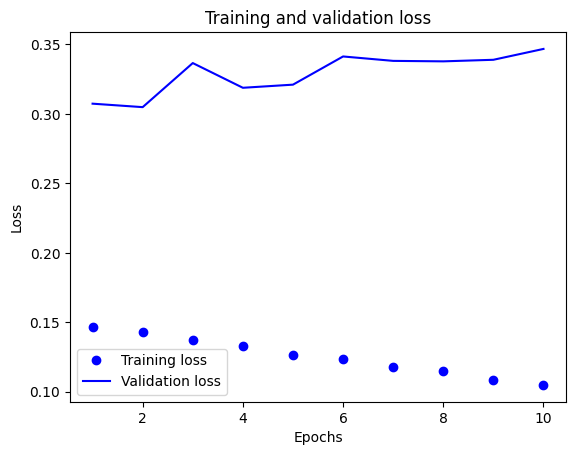

In [50]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

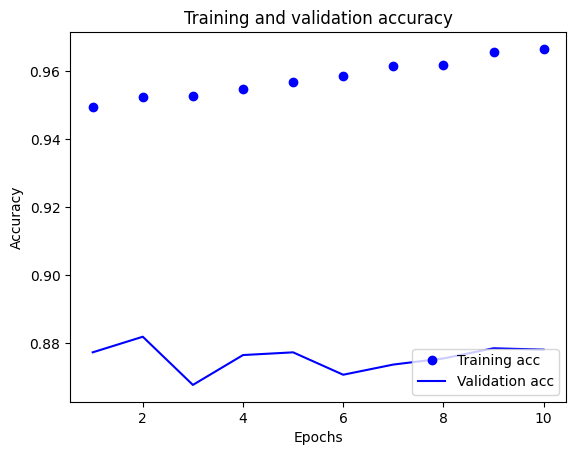

In [51]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [58]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_dataset`, which yields raw strings
accuracy = export_model.evaluate(raw_test_dataset)

print(accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5040 - binary_accuracy: 0.0000e+00 - loss: 0.0000e+00
[0.0, 0.0, 0.0, 0.505840003490448]


In [61]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible...",
  "I just watched this movie, I am happy to see it, its amzing, marvelous, gorgeous, cool"
])

predictions = export_model.predict(examples)

for i, prediction in enumerate(predictions):
    print(f"Sentence: '{examples[i].numpy().decode()}' -> Prediction: {prediction[0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Sentence: 'The movie was great!' -> Prediction: 0.6169
Sentence: 'The movie was okay.' -> Prediction: 0.5517
Sentence: 'The movie was terrible...' -> Prediction: 0.5335
Sentence: 'I just watched this movie, I am happy to see it, its amzing, marvelous, gorgeous, cool' -> Prediction: 0.6502
